# GAN 구조

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Generator 모델 정의
def build_generator():
    inputs = keras.Input(shape=(1,))  # 입력 z (0 ~ 1 사이 랜덤 값)
    x = layers.Dense(3)(inputs)  # 3개의 출력을 생성
    outputs = layers.Activation('sigmoid')(x)  # sigmoid 활성화 함수로 0 ~ 1 사이 값으로 변환
    model = keras.Model(inputs, outputs)
    return model

# Discriminator 모델 정의
def build_discriminator():
    inputs = keras.Input(shape=(3,))  # Generator의 출력을 입력으로 받음 (x1, x2, x3)
    x = layers.Dense(1)(inputs)  # 하나의 출력 생성
    outputs = layers.Activation('sigmoid')(x)  # sigmoid 활성화 함수로 확률 값 출력
    model = keras.Model(inputs, outputs)
    return model

# Generator와 Discriminator 인스턴스 생성
G = build_generator()
D = build_discriminator()

# Optimizer 및 Loss 설정
G_optimizer = tf.keras.optimizers.Adam(1e-3)
D_optimizer = tf.keras.optimizers.Adam(1e-3)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# 손실 함수 정의
def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 실제 데이터의 손실
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜 데이터의 손실
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Generator가 가짜 데이터를 실제로 보이게 하도록 학습

# 훈련 스텝 정의
@tf.function
def train_step():
    noise = tf.random.uniform([1, 1], minval=0.0, maxval=1.0)  # 랜덤 z 값 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        # Generator로 가짜 데이터 생성
        generated_data = G(noise, training=True)

        # Discriminator로 실제 및 가짜 데이터 평가
        real_output = D(np.array([[1.0, 0.0, 0.0]]), training=True)  # 실제 데이터 예시
        fake_output = D(generated_data, training=True)

        # 손실 계산
        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
    
    # Gradient 계산 및 적용
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

    return gen_loss, dsc_loss

# 훈련 함수 정의
def train(epochs):
    for epoch in range(epochs):
        gen_loss, dsc_loss = train_step()
        
        # 100 에포크마다 손실 출력
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Generator loss: {gen_loss.numpy()}, Discriminator loss: {dsc_loss.numpy()}")

# 학습 실행
EPOCHS = 1000
train(EPOCHS)

# 테스트: 랜덤 입력을 통해 Generator의 출력 확인
test_noise = tf.random.uniform([1, 1], minval=0.0, maxval=1.0)
generated_sample = G(test_noise, training=False)
print("Generated sample:", generated_sample.numpy())


Epoch 0, Generator loss: 0.7300354242324829, Discriminator loss: 1.2667890787124634
Epoch 100, Generator loss: 0.7781919836997986, Discriminator loss: 1.2131330966949463
Epoch 200, Generator loss: 0.8077847957611084, Discriminator loss: 1.1692357063293457
Epoch 300, Generator loss: 0.8255212903022766, Discriminator loss: 1.142652153968811
Epoch 400, Generator loss: 0.8196117877960205, Discriminator loss: 1.1420214176177979
Epoch 500, Generator loss: 0.8059509992599487, Discriminator loss: 1.1504268646240234
Epoch 600, Generator loss: 0.8048125505447388, Discriminator loss: 1.1538989543914795
Epoch 700, Generator loss: 0.7687203884124756, Discriminator loss: 1.1839511394500732
Epoch 800, Generator loss: 0.8615353107452393, Discriminator loss: 1.1136949062347412
Epoch 900, Generator loss: 0.8195438385009766, Discriminator loss: 1.1527061462402344
Generated sample: [[0.8640268  0.11647838 0.1277414 ]]


==============EASY

### TF예제 : https://www.tensorflow.org/tutorials/generative/dcgan 

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 4.3MB 53.5MB/s 
     |████████████████████████████████| 501kB 47.1MB/s 


참고 링크 : [Tensorflow GAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [18]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [19]:
train_images.shape

(60000, 28, 28)

In [20]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5
# 마지막 layer의 활성화 함수로 sigmoid(0~1) 보다 tanh(-1~1)를 더 선호합니다.

In [21]:
train_images.shape

(60000, 28, 28, 1)

In [22]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Vanila GAN

In [23]:
# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
x = inputs
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(28*28, activation = 'tanh')(x)
outputs = layers.Reshape((28,28))(x)

In [ ]:
G = keras.Model(inputs, outputs)
G.summary()

In [25]:
# Discriminaotr 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)

In [ ]:
D = keras.Model(inputs, outputs)
D.summary()

(1, 100)


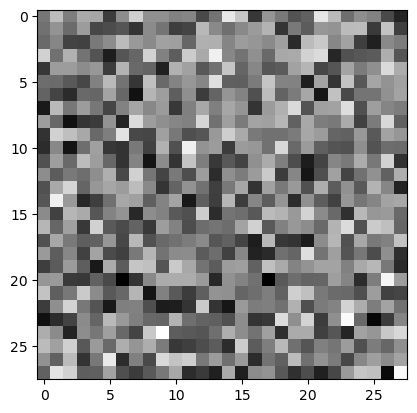

In [27]:
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise = tf.random.normal([1, 100])
print( test_noise.shape)
fake_image_test = G(test_noise, training=False)

plt.imshow(fake_image_test[0], cmap='gray')

In [28]:
# 그리고 G모델에서 만들어진 이미지를 D모델에 통과시키면 확률이 나오게 됩니다.
decision = D(fake_image_test, training=False)
print(decision)

tf.Tensor([[0.11493634]], shape=(1, 1), dtype=float32)


# GAN 훈련 구현
 - G모델, D모델을 훈련시킬 Loss를 생성해줍니다.
 - G모델과 D모델을 순서대로 훈련시키는 과정을 반복합니다.

In [29]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        fake_images = G(noises, training=True)

        real_output = D(real_images, training=True)
        fake_output = D(fake_images, training=True)

        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
    
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)

    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

In [32]:
def test_step(real_images):  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])

    fake_images = G(noises, training=False)
    real_output = D(real_images, training=False)
    fake_output = D(fake_images, training=False)    

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [33]:
# 학습 함수

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(dataset):
            train_step(image_batch)
            if i == 0:
                test_step(image_batch)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [38]:
%%time
# train(train_dataset, EPOCHS)
train(train_dataset, 200)

Generator loss: 1.0336001 Discriminator loss: 1.0442877
Time for epoch 1 is 1.3988420963287354 sec
Generator loss: 0.94769907 Discriminator loss: 0.9936445
Time for epoch 2 is 1.4821171760559082 sec
Generator loss: 0.92300195 Discriminator loss: 1.0458394
Time for epoch 3 is 1.5641419887542725 sec
Generator loss: 1.0034996 Discriminator loss: 1.0011433
Time for epoch 4 is 1.442169427871704 sec
Generator loss: 1.0252225 Discriminator loss: 1.0242132
Time for epoch 5 is 1.441028356552124 sec
Generator loss: 1.1084676 Discriminator loss: 1.0225234
Time for epoch 6 is 1.66019868850708 sec
Generator loss: 0.8880217 Discriminator loss: 1.0678393
Time for epoch 7 is 1.5133564472198486 sec
Generator loss: 0.94017994 Discriminator loss: 1.0273715
Time for epoch 8 is 1.5773341655731201 sec
Generator loss: 0.90551126 Discriminator loss: 1.064332
Time for epoch 9 is 1.795400619506836 sec
Generator loss: 0.8404882 Discriminator loss: 1.0868233
Time for epoch 10 is 1.6865172386169434 sec
Generator l

Time for epoch 83 is 1.4413611888885498 sec
Generator loss: 0.9593183 Discriminator loss: 1.0740062
Time for epoch 84 is 1.4209513664245605 sec
Generator loss: 0.9251372 Discriminator loss: 1.0692099
Time for epoch 85 is 1.4193625450134277 sec
Generator loss: 1.0033648 Discriminator loss: 1.0811076
Time for epoch 86 is 1.4150137901306152 sec
Generator loss: 0.9760516 Discriminator loss: 1.0717483
Time for epoch 87 is 1.4334909915924072 sec
Generator loss: 0.9210078 Discriminator loss: 1.0312606
Time for epoch 88 is 1.4379281997680664 sec
Generator loss: 0.94418216 Discriminator loss: 1.0659448
Time for epoch 89 is 1.430255651473999 sec
Generator loss: 0.86126506 Discriminator loss: 1.0765966
Time for epoch 90 is 1.4239633083343506 sec
Generator loss: 0.89016724 Discriminator loss: 1.0881354
Time for epoch 91 is 1.4327046871185303 sec
Generator loss: 0.8634237 Discriminator loss: 1.1003029
Time for epoch 92 is 1.4297435283660889 sec
Generator loss: 0.8269031 Discriminator loss: 1.101365

Time for epoch 165 is 1.4325323104858398 sec
Generator loss: 0.87044376 Discriminator loss: 1.0704594
Time for epoch 166 is 1.4346730709075928 sec
Generator loss: 0.84955704 Discriminator loss: 1.1066514
Time for epoch 167 is 1.4211463928222656 sec
Generator loss: 0.88987803 Discriminator loss: 1.0990207
Time for epoch 168 is 1.445643424987793 sec
Generator loss: 0.9333379 Discriminator loss: 1.1067659
Time for epoch 169 is 1.4610340595245361 sec
Generator loss: 0.8791864 Discriminator loss: 1.1051284
Time for epoch 170 is 1.419973373413086 sec
Generator loss: 0.97151804 Discriminator loss: 1.1130137
Time for epoch 171 is 1.457648754119873 sec
Generator loss: 0.9034184 Discriminator loss: 1.1111426
Time for epoch 172 is 1.5237059593200684 sec
Generator loss: 0.96371377 Discriminator loss: 1.1336129
Time for epoch 173 is 1.4624319076538086 sec
Generator loss: 0.8896505 Discriminator loss: 1.10769
Time for epoch 174 is 1.4575049877166748 sec
Generator loss: 0.90056956 Discriminator loss:

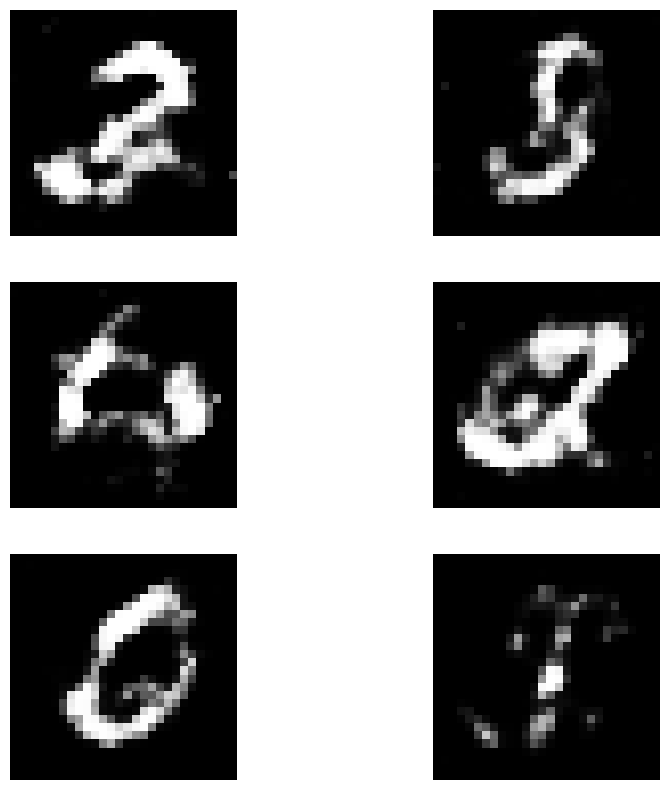

In [39]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
    ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')

plt.show()

# Deep Convolutional GAN

In [26]:
# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
x = inputs
x = layers.Dense(7*7*256, use_bias=False, input_shape=(100,))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
outputs = x

In [27]:
G = keras.Model(inputs, outputs)
G.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                   

In [28]:
# Discriminaotr 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28,1))
x = inputs
x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                  input_shape=[28, 28, 1])(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(1)(x)
outputs = x

In [29]:
D = keras.Model(inputs, outputs)
D.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0   

In [30]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [32]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        fake_images = G(noises, training=True)

        real_output = D(real_images, training=True)
        fake_output = D(fake_images, training=True)

        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
    
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)

    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))
  

In [33]:
def test_step(real_images):  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])

    fake_images = G(noises, training=False)

    real_output = D(real_images, training=False)
    fake_output = D(fake_images, training=False)    

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [34]:
# 학습 함수

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
    
        for i, image_batch in enumerate(dataset):
            train_step(image_batch)
            if i == 0:
                test_step(image_batch)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [ ]:
%%time
train(train_dataset, EPOCHS)

Generator loss: 0.6921196 Discriminator loss: 1.3233724
Generator loss: 0.8235857 Discriminator loss: 1.6412483
Generator loss: 0.97856325 Discriminator loss: 1.0933657
Generator loss: 1.2544522 Discriminator loss: 0.86434174
Generator loss: 0.85938 Discriminator loss: 1.1838602
Generator loss: 0.8591795 Discriminator loss: 1.2134798
Generator loss: 0.99405324 Discriminator loss: 1.2555952
Generator loss: 0.86937696 Discriminator loss: 1.3503122
Generator loss: 0.9863498 Discriminator loss: 1.1350005
Generator loss: 1.172579 Discriminator loss: 0.94009656


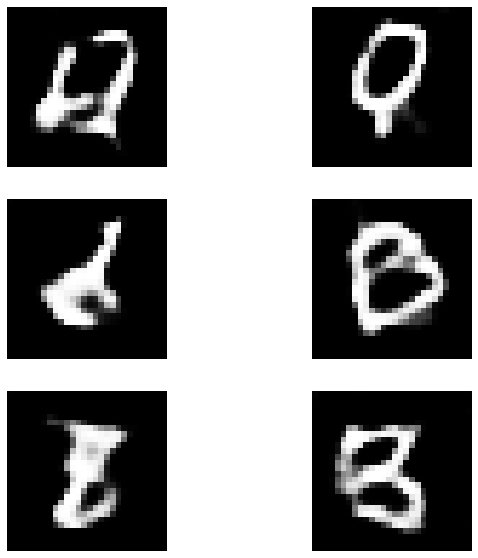

In [ ]:
noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
    ax.axis('off')

axes[0,0].imshow(generated_image[0][:,:,0], cmap='gray')
axes[0,1].imshow(generated_image[1][:,:,0], cmap='gray')
axes[1,0].imshow(generated_image[2][:,:,0], cmap='gray')
axes[1,1].imshow(generated_image[3][:,:,0], cmap='gray')
axes[2,0].imshow(generated_image[4][:,:,0], cmap='gray')
axes[2,1].imshow(generated_image[5][:,:,0], cmap='gray')

plt.show()

# Conditional GAN
  - Mnist는 숫자 데이터이니까, 숫자 정보를 추가로 넣어줍니다.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5

In [ ]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
train_label_onehots.shape

(60000, 10)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 200


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_label_onehots)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise + label
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
conditions = keras.Input(shape=(10,))

x = layers.concatenate([inputs, conditions])
x = layers.Dense(7*7*128, use_bias=False, input_shape=(100,))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
outputs = x

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 6272)         689920      concatenate_2[0][0]        

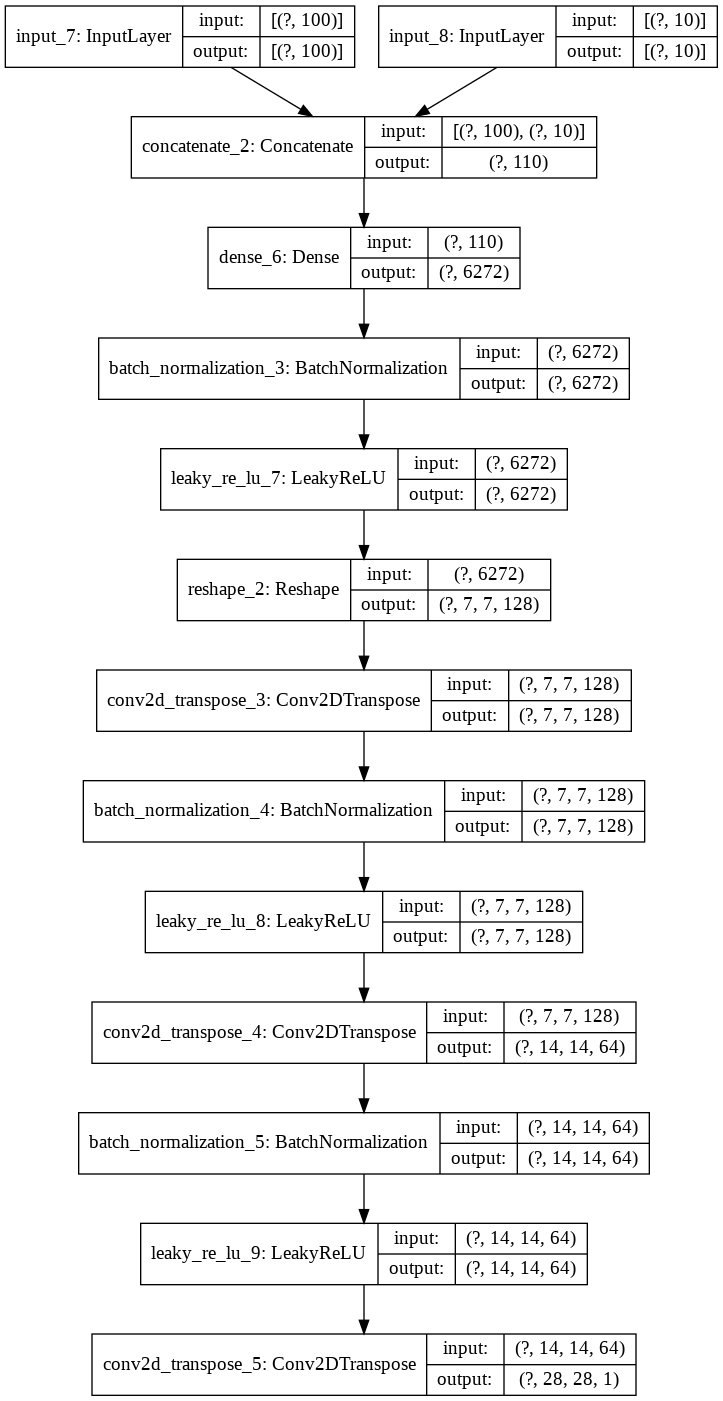

In [ ]:
G = keras.Model([inputs, conditions], outputs)
G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)


In [ ]:
# Discriminaotr 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28) + label
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28,1))
conditions = keras.Input(shape=(10,))

x_c = layers.Dense(28*28)(conditions)
x_c = layers.Reshape((28,28,1))(x_c)

x = layers.concatenate([inputs,x_c])

x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(1)(x)
outputs = x

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 784)          8624        input_14[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 28, 28, 1)    0           dense_10[0][0]                   
____________________________________________________________________________________________

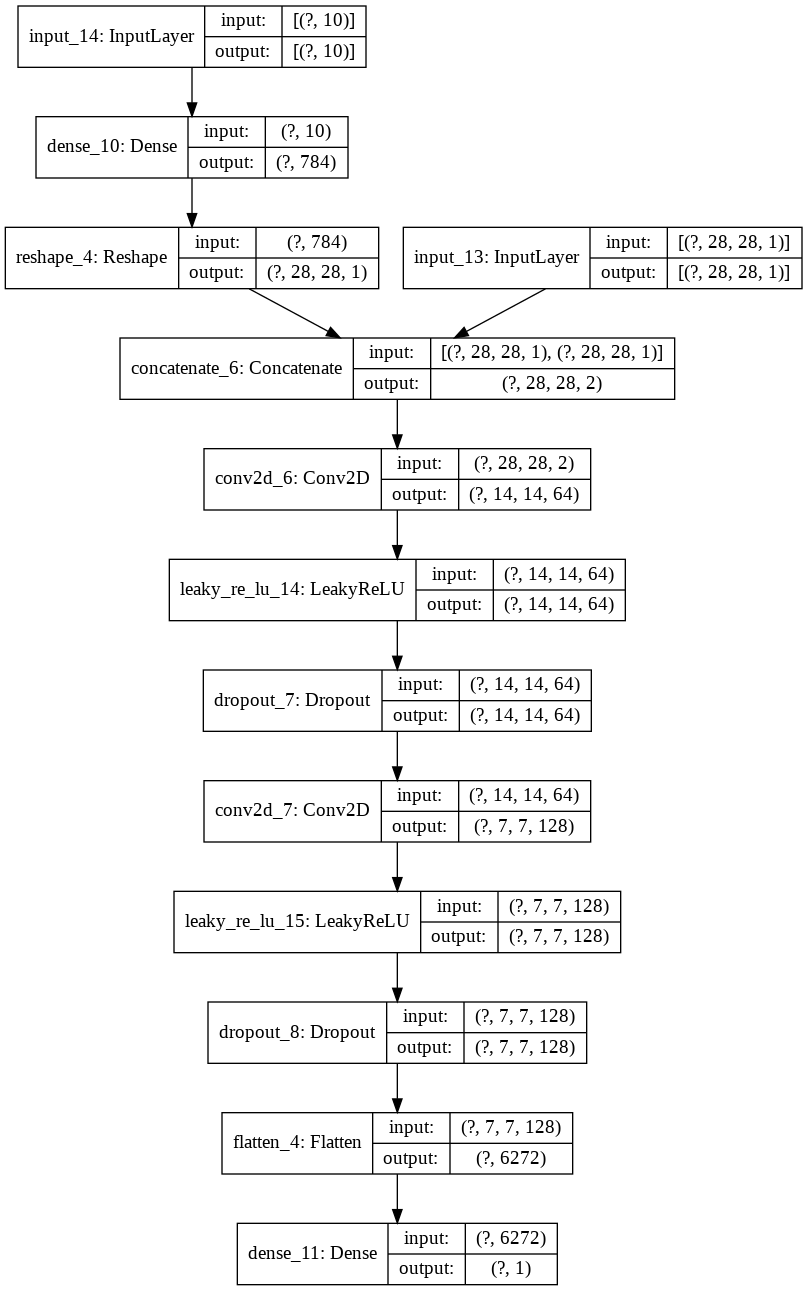

In [ ]:
D = keras.Model([inputs,conditions], outputs)
D.summary()
tf.keras.utils.plot_model(D, 'discriminator.png', show_shapes=True)

In [ ]:
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(real_images, real_conditions):  
  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises, real_conditions], training=True)
    
    real_output = D([real_images, real_conditions], training=True)
    fake_output = D([fake_images, real_conditions], training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

In [ ]:
def test_step(real_images, real_conditions):  
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
  fake_images = G([noises, real_conditions], training=False)
  
  real_output = D([real_images, real_conditions], training=False)
  fake_output = D([fake_images, real_conditions], training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())
  
  return gen_loss.numpy(), dsc_loss.numpy()

In [ ]:
def plot_loss(losses) :
  plt.figure(figsize=(10,10))

  plt.plot(losses[0], label="Generator losses")
  plt.plot(losses[1], label="Discriminator losses")
  plt.xlabel("Epochs")
  plt.ylabel("Losses")
  plt.legend()
  plt.show()

In [ ]:
def train(dataset, epochs):
  gen_losses = []
  dsc_losses = []
  
  for epoch in range(epochs):
    start = time.time()
    
    for i, image_batch in enumerate(dataset):
      train_step(image_batch[0],image_batch[1])
      if i == 0:
        gen_loss, dsc_loss = test_step(image_batch[0],image_batch[1])
        gen_losses.append(gen_loss)
        dsc_losses.append(dsc_loss)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  losses = [gen_losses, dsc_losses]
  plot_loss(losses)

Generator loss: 0.6996026 Discriminator loss: 1.3773465
Time for epoch 1 is 13.66992735862732 sec
Generator loss: 0.7216554 Discriminator loss: 1.427736
Time for epoch 2 is 12.01568055152893 sec
Generator loss: 0.68067026 Discriminator loss: 1.3805631
Time for epoch 3 is 12.070750713348389 sec
Generator loss: 0.61324525 Discriminator loss: 1.720166
Time for epoch 4 is 12.168156385421753 sec
Generator loss: 0.99479103 Discriminator loss: 1.0874
Time for epoch 5 is 13.104275226593018 sec
Generator loss: 0.84412855 Discriminator loss: 1.2915034
Time for epoch 6 is 12.160940647125244 sec
Generator loss: 1.0424879 Discriminator loss: 1.0222336
Time for epoch 7 is 12.102155923843384 sec
Generator loss: 0.902467 Discriminator loss: 1.1208334
Time for epoch 8 is 12.175405740737915 sec
Generator loss: 0.9016713 Discriminator loss: 1.1482687
Time for epoch 9 is 12.235955238342285 sec
Generator loss: 1.0806456 Discriminator loss: 1.0202556
Time for epoch 10 is 12.133088111877441 sec
Generator los

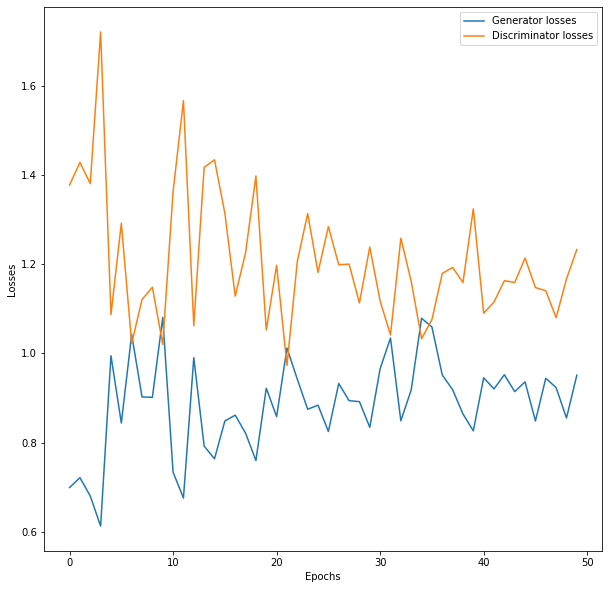

In [ ]:
# 학습!!!
EPOCHS = 50
import time
train(train_dataset, EPOCHS)

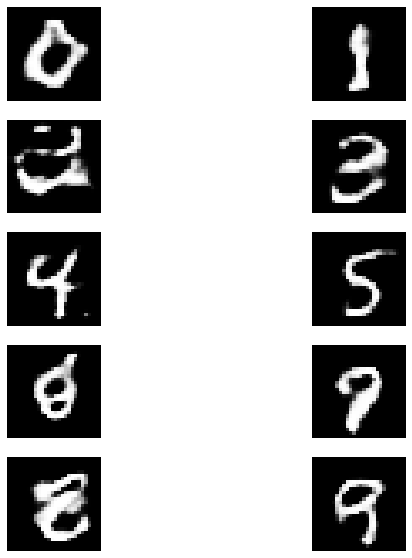

In [ ]:
noises = tf.random.normal([10, 100])
labels = np.array([
                [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
                ], dtype=np.float32)
generated_image = G([noises, labels], training=False)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0][:,:,0], cmap='gray')
axes[0,1].imshow(generated_image[1][:,:,0], cmap='gray')
axes[1,0].imshow(generated_image[2][:,:,0], cmap='gray')
axes[1,1].imshow(generated_image[3][:,:,0], cmap='gray')
axes[2,0].imshow(generated_image[4][:,:,0], cmap='gray')
axes[2,1].imshow(generated_image[5][:,:,0], cmap='gray')
axes[3,0].imshow(generated_image[6][:,:,0], cmap='gray')
axes[3,1].imshow(generated_image[7][:,:,0], cmap='gray')
axes[4,0].imshow(generated_image[8][:,:,0], cmap='gray')
axes[4,1].imshow(generated_image[9][:,:,0], cmap='gray')


plt.show()